# This notebook contains an example of running CiSSA on auto mode.
## The only parameter that the user MUST set is the window length, L.
Even if the user does not set L explicitly, auto-cissa will take L to be half the time series length.  
If needed, auto-cissa will:
- a) Fix any censored data
- b) Replace any NaN values using cissa gap fill method
- c) Fit the data using CiSSA
- d) Find significant components using a Monte-Carlo procedure
- e) Group components into trend, periodic, and noise groups.
- f) Run frequency time analysis, plot trend and other figures.

In [1]:
#importing required packages
import pandas as pd
import numpy as np
import os
os.chdir('../../..')
home_path = os.path.abspath('')
from pycissa import Cissa
os.chdir(home_path)

In [2]:
## Read data file  (source is the Ministry of Economy of Spain.)
data = pd.read_excel(home_path + r'/data/EPC.xlsx',sheet_name = 'Data')

In [3]:
#create the cissa object
cissa_object = Cissa(t=data['Date'],x=data['Electric power consumption in Spain'])

In [4]:
#here we choose a window length of 5 years.
cissa_object.auto_cissa(L = 12*5,
                       K_surrogates = 5, alpha = 0.05,  #settings some parameters for the Monte-Carlo routine
                       )

Checking for censored or nan data...
RUNNING CISSA!
Performing monte-carlo significance analysis...
Grouping components...
Running frequency time analysis...
Analysing trend...
Calculating time-series autocorrelation...
running peridogram analysis

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -74.087         True       1.1711 
1                    -76.927         True      0.81719 

Min BIC (Bayesian Information Criterion) suggests best model
Auto Cissa Complete!


### Firstly, let us view the original time series and how the CiSSA method has split the components:

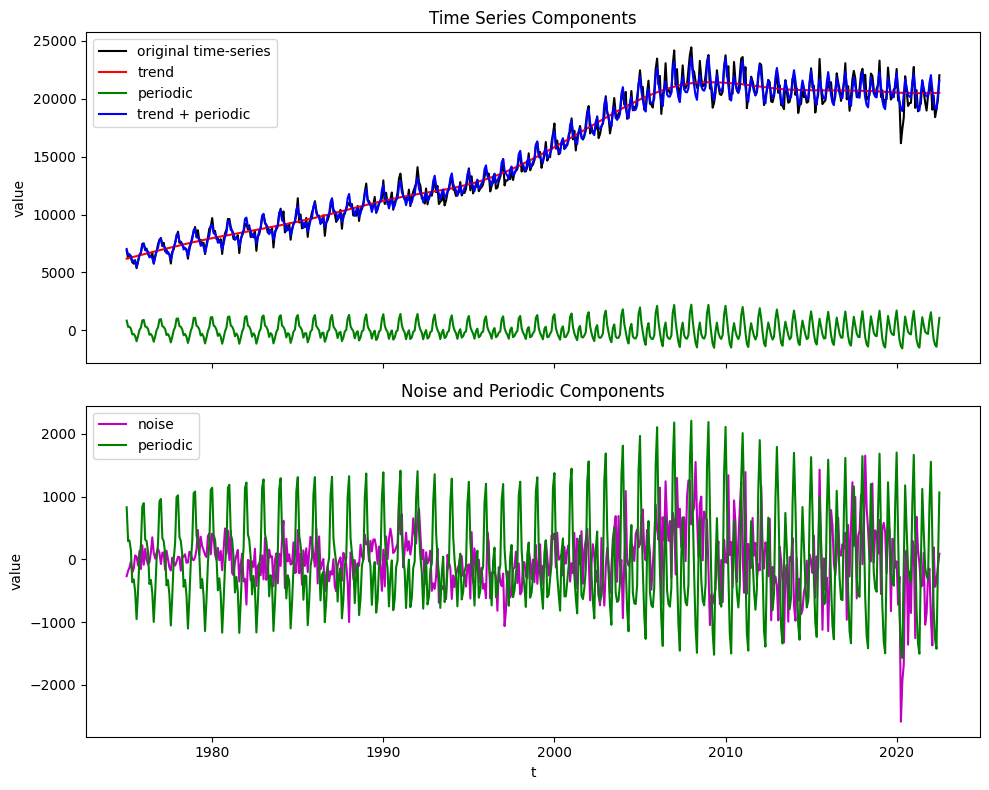

In [5]:
cissa_object.figures.get('cissa').get('figure_split_components')

In [6]:
print('''COMPONENT VARIANCE''')
print(f'''TREND   : {cissa_object.results.get('cissa').get('noise component tests').get('trend_share')}%''')
print(f'''PERIODIC: {cissa_object.results.get('cissa').get('noise component tests').get('periodic_share')}%''')
print(f'''NOISE   : {cissa_object.results.get('cissa').get('noise component tests').get('noise_share')}%''')

COMPONENT VARIANCE
TREND   : 93.02771796669813%
PERIODIC: 2.1763174117463193%
NOISE   : 4.5342693711415185%


### Now we will look at the significant components:

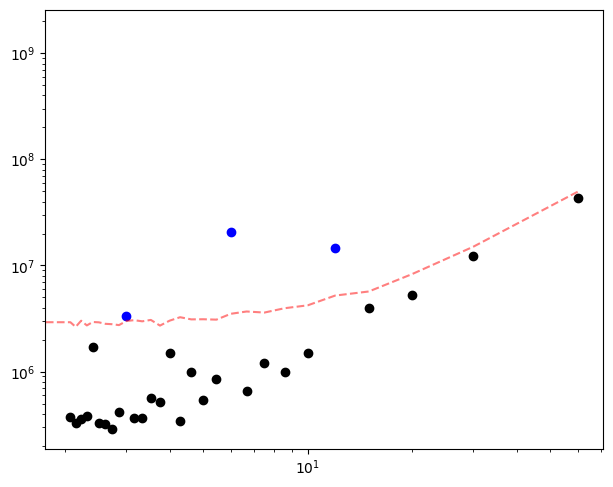

In [7]:
cissa_object.figures.get('cissa').get('figure_monte_carlo')

In [8]:
#here we iterate through the results and find the frequencies that passed monte-carlo test.
#Note the result dictionary is structured according to input options.
#We also convert the frequency to period in years since we have monthly data
print("Trend is included in significant components.")
print(" ")
for key_j in cissa_object.results.get('cissa').get('components').keys():
    if key_j != 'trend':
        if cissa_object.results.get('cissa').get('components').get(key_j).get('monte_carlo').get('random_permutation').get('alpha').get(0.05).get('pass'):
            print("Significant CiSSA component found!")
            print(f" Frequency = {key_j} per unit timestep")
            print(f"Period = {1/(12*key_j)} years")
            print(" ")

Trend is included in significant components.
 
Significant CiSSA component found!
 Frequency = 0.08333333333333333 per unit timestep
Period = 1.0 years
 
Significant CiSSA component found!
 Frequency = 0.16666666666666666 per unit timestep
Period = 0.5 years
 
Significant CiSSA component found!
 Frequency = 0.3333333333333333 per unit timestep
Period = 0.25 years
 


### Next we will look at the trend...

Since L is set at 5 years (L=12*5) then trend is defined as any signal component with period longer than 5 years

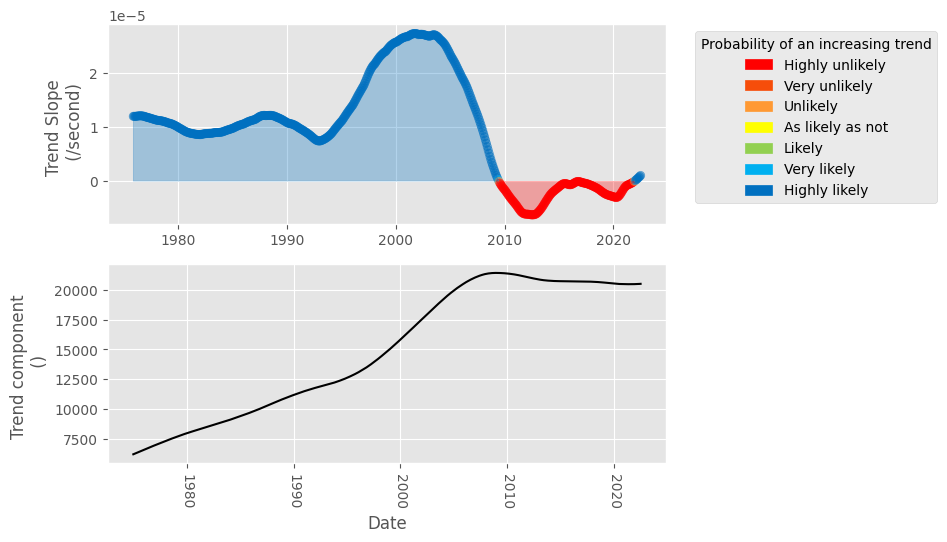

In [9]:
cissa_object.figures.get('cissa').get('figure_trend')

### Next we will look at the frequency time analysis...

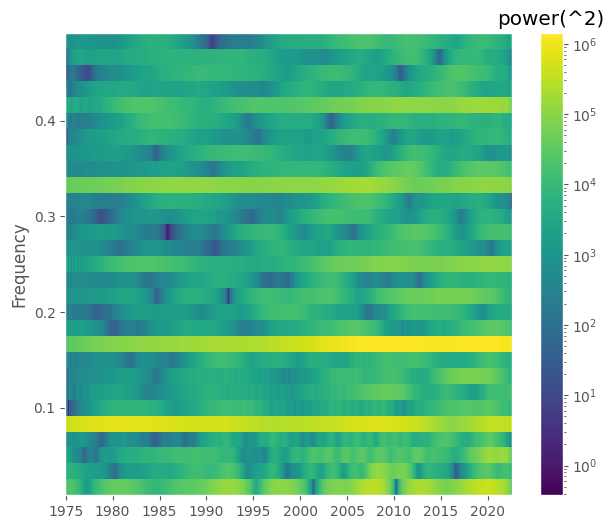

In [10]:
cissa_object.figures.get('cissa').get('figure_frequency_time')

The 1 year signal seems to have the strongest signal power, but the six month signal power greatly increases towards the end of the time series.  

### Looking now at the noise residuals

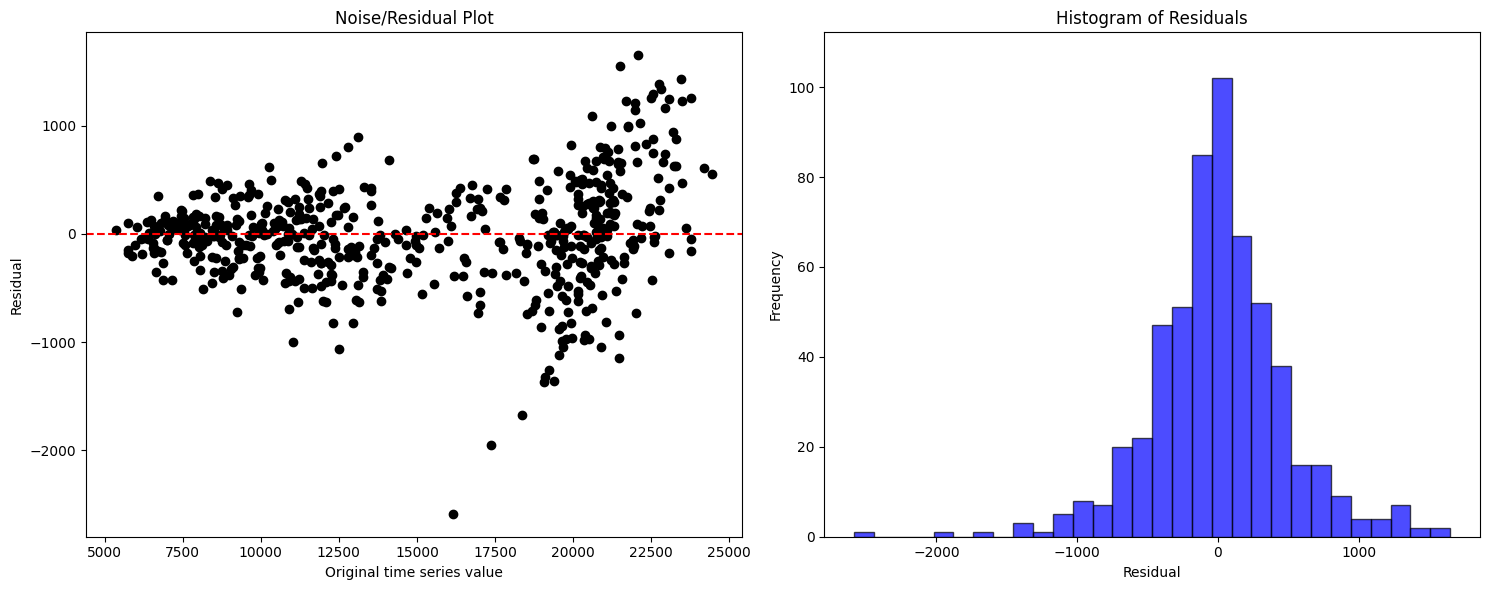

In [11]:
cissa_object.figures.get('cissa').get('figure_residual_check')

### We can access the last 5 values of the trend, periodic, and noise components

In [14]:
print("TREND")
print(np.column_stack((cissa_object.t[-5:].astype(str), cissa_object.x_trend[-5:].astype(str))))
print(" ")

print("PERIODIC")
print(np.column_stack((cissa_object.t[-5:].astype(str), cissa_object.x_periodic[-5:].astype(str))))
print(" ")

print("NOISE/RESIDUAL")
print(np.column_stack((cissa_object.t[-5:].astype(str), cissa_object.x_noise[-5:].astype(str))))
print(" ")


TREND
[['2022-03-01T00:00:00.000000000' '20496.40069301314']
 ['2022-04-01T00:00:00.000000000' '20500.005685530366']
 ['2022-05-01T00:00:00.000000000' '20504.13368216877']
 ['2022-06-01T00:00:00.000000000' '20508.7510698886']
 ['2022-07-01T00:00:00.000000000' '20513.9417403252']]
 
PERIODIC
[['2022-03-01T00:00:00.000000000' '-785.1692232487726']
 ['2022-04-01T00:00:00.000000000' '-1275.694401957415']
 ['2022-05-01T00:00:00.000000000' '-1424.9850251216674']
 ['2022-06-01T00:00:00.000000000' '-80.0808339894312']
 ['2022-07-01T00:00:00.000000000' '1064.5066624216768']]
 
NOISE/RESIDUAL
[['2022-03-01T00:00:00.000000000' '189.46278645993596']
 ['2022-04-01T00:00:00.000000000' '-437.59548311323425']
 ['2022-05-01T00:00:00.000000000' '-340.346590069676']
 ['2022-06-01T00:00:00.000000000' '-111.29659923231006']
 ['2022-07-01T00:00:00.000000000' '89.32891965875535']]
 


These components can be used to detrend, denoise a signal, or used in a prediction model.